# Ratio cell to IRIS

In [1]:
import numpy as np
import pandas as pd
import tensorly as tl
import time
from tqdm import tqdm

import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colrs

from descartes.patch import PolygonPatch

from my_lib import common
import folium
from shapely.geometry import Point, mapping, box
from shapely.geometry import shape as Shape
from shapely.ops import transform as Shapely_transform

import mapply

In [2]:
# Font
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['CMU Serif Roman'] + plt.rcParams['font.serif']
plt.rcParams['font.size'] = 18

wgs_to_ntf = common.transform_wgs_to_ntf()
ntf_to_wgs = common.transform_ntf_to_wgs()

mapply.init(
    n_workers=37,
    chunk_size=1,
    progressbar=True
)

## Load data

In [3]:
WORKING_DIR = '/home/jupyter-landy/data/Land_use'
DATA_DIR = f'{WORKING_DIR}/data'
METROPOLES_SHAPE = f'{DATA_DIR}/cities'
IMG_DIR = f'{WORKING_DIR}/images'

CITY_NAME = 'Paris'

### Load IRIS

In [4]:
def fix_iris_code(code):
    return str(code).zfill(9)

In [5]:
df_iris = gpd.read_file(f'{DATA_DIR}/iris_2019/CONTOURS-IRIS.shp')
df_iris = df_iris[['CODE_IRIS', 'geometry']]
df_iris.rename(columns={'CODE_IRIS': 'iris_code'}, inplace=True)
df_iris['iris_code'] = df_iris.apply(lambda row: fix_iris_code(row['iris_code']), axis=1)
df_iris = df_iris.to_crs(4326)

# Lat-Lon
df_iris['geometry'] = df_iris.mapply(lambda row: Shapely_transform(lambda x,y: (y, x), row['geometry']), axis=1)
df_iris['geometry_ntf'] = df_iris.mapply(lambda row: Shapely_transform(wgs_to_ntf, row['geometry']), axis=1)

df_iris.head(2)

  0%|          | 0/392 [00:00<?, ?it/s]

  0%|          | 0/392 [00:00<?, ?it/s]

,iris_code,geometry,geometry_ntf
0,721910000,"POLYGON ((47.79825 0.29973, 47.79822 0.29999, ...","POLYGON ((447423.2777117738 2312959.093463689,..."
1,772480000,"POLYGON ((48.91716 2.80567, 48.91471 2.80670, ...","POLYGON ((634405.9397396996 2435536.947532415,..."


### Load masks

In [6]:
df_masks = pd.read_pickle(f'{DATA_DIR}/df_masks.pkl')
df_masks.head(2)

,name,shape,extended_shape,mask,left_x,bottom_y
0,Toulouse,"POLYGON ((43.534422912658 1.3719996818556, 43....","POLYGON ((43.421730580752 1.380982673039302, 4...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",508400,1835400
1,Nantes,"POLYGON ((47.115627733018 -1.6090552897103, 47...","POLYGON ((47.01977245812861 -1.58097675820976,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",278200,2241200


In [7]:
cities_shapes = {}

for city in df_masks.to_dict('records'):
    city_name = city['name']
    city_shape = city['shape']
    left_x = city['left_x']
    bottom_y = city['bottom_y']
    mask = city['mask']
    bbox = city_shape.bounds
    cities_shapes[city_name] = {
        'shape': city_shape,
        'bbox': bbox,
        'left_x': left_x,
        'bottom_y': bottom_y,
        'mask': mask
    }

del cities_shapes['Rouen']

cities_shapes = {k:v for k,v in sorted(cities_shapes.items(), key=lambda x: x[0])}

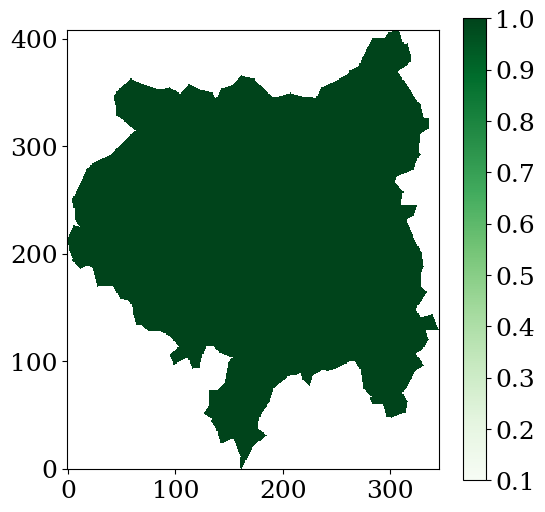

In [8]:
city_data = cities_shapes[CITY_NAME]

city_shape = city_data['shape']
city_mask = city_data['mask']
city_n_rows = city_mask.shape[0]
city_n_cols = city_mask.shape[1]
city_left_x = city_data['left_x']
city_bottom_y = city_data['bottom_y']

city_centroid = city_shape.centroid

my_cmap_mask = cm.get_cmap('Greens').copy()
my_cmap_mask.set_under('w', 0)
norm_mask = colrs.Normalize(vmin=0.1, vmax=1)

plt.figure(figsize=(6, 6))
plt.imshow(city_mask, origin='lower', cmap=my_cmap_mask, norm=norm_mask, interpolation='nearest')
plt.colorbar()
plt.show()

### Assign city to IRIS

In [9]:
def get_city(iris_shape):
    for city_name in cities_shapes:
        if city_name == 'France':
            continue

        city_shape = cities_shapes[city_name]['shape']
    
        shape_intercept = city_shape.intersection(iris_shape)
        ratio = shape_intercept.area/iris_shape.area
        if ratio > 0:
            return city_name, ratio
    return None, None

In [10]:
df_iris[['city', 'iris_inside_ratio']] = df_iris.mapply(lambda row: get_city(row['geometry']), axis=1, result_type='expand')
df_iris.head(2)

  0%|          | 0/392 [00:00<?, ?it/s]

,iris_code,geometry,geometry_ntf,city,iris_inside_ratio
0,721910000,"POLYGON ((47.79825 0.29973, 47.79822 0.29999, ...","POLYGON ((447423.2777117738 2312959.093463689,...",None,NaN
1,772480000,"POLYGON ((48.91716 2.80567, 48.91471 2.80670, ...","POLYGON ((634405.9397396996 2435536.947532415,...",None,NaN


## IRIS selection

In [11]:
df_iris_city = df_iris[df_iris['city'] == CITY_NAME].copy()

df_iris_city.head(2)

,iris_code,geometry,geometry_ntf,city,iris_inside_ratio
36,920440109,"POLYGON ((48.89379 2.29154, 48.89362 2.29113, ...","POLYGON ((596701.1538090943 2432835.103953797,...",Paris,1.0
57,930270105,"POLYGON ((48.92059 2.41055, 48.91992 2.40987, ...","POLYGON ((605429.7061786579 2435817.931119842,...",Paris,1.0


### Plot city's Iris

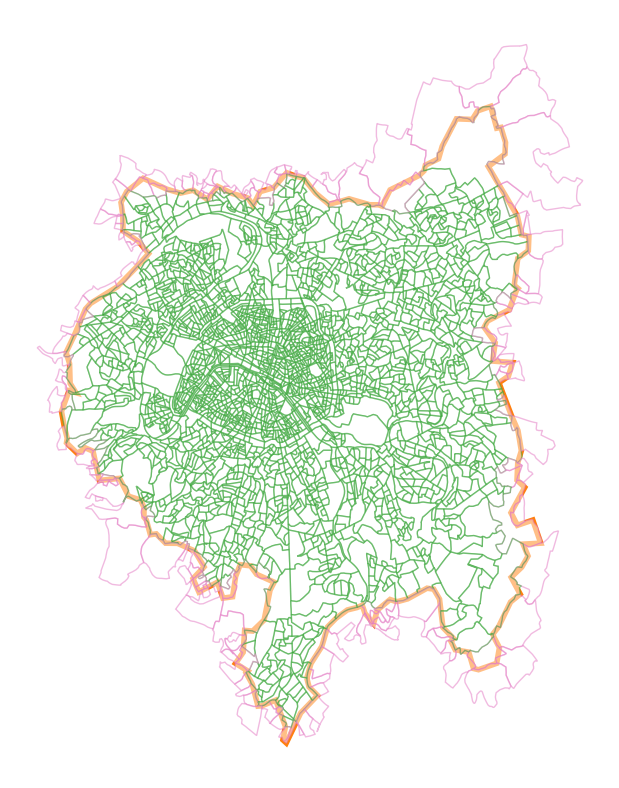

In [12]:
min_x, min_y, max_x, max_y = city_shape.bounds
ratio = (max_y - min_y)/(max_x - min_x)

dim_width = 6
dim_height = 6 *ratio


fig = plt.figure(figsize=(dim_width, dim_height))
ax = fig.add_axes([0, 0, 1, 1])

city_shape_lon_lat = Shapely_transform(lambda x,y: (y, x), city_shape)
patch = PolygonPatch(city_shape_lon_lat, fc='white', ec='tab:orange', alpha=1, lw=4)
ax.add_patch(patch)

iris_shapes = list(df_iris_city['geometry'])
iris_ratios = list(df_iris_city['iris_inside_ratio'])

for iris_shape, iris_ratio in zip(iris_shapes, iris_ratios):
    iris_shape_to_plot = Shapely_transform(lambda x,y: (y, x), iris_shape)

    if iris_ratio < .95:
        patch = PolygonPatch(iris_shape_to_plot, fc='white', ec='tab:pink', alpha=.5, lw=1)
    else:
        patch = PolygonPatch(iris_shape_to_plot, fc='white', ec='tab:green', alpha=.5, lw=1)

    ax.add_patch(patch)


plt.autoscale(True)
plt.axis('off')

plt.show()

### Only keep IRIS inside city

In [13]:
print(f'Number of iris: {df_iris_city.shape[0]}')

Number of iris: 2955


In [14]:
df_iris_city = df_iris_city[df_iris_city['iris_inside_ratio'] >= .95].copy()
df_iris_city.head(2)

,iris_code,geometry,geometry_ntf,city,iris_inside_ratio
36,920440109,"POLYGON ((48.89379 2.29154, 48.89362 2.29113, ...","POLYGON ((596701.1538090943 2432835.103953797,...",Paris,1.0
57,930270105,"POLYGON ((48.92059 2.41055, 48.91992 2.40987, ...","POLYGON ((605429.7061786579 2435817.931119842,...",Paris,1.0


In [15]:
print(f'Number of iris after filtering: {df_iris_city.shape[0]}')

Number of iris after filtering: 2800


### Set IRIS integer ID

In [16]:
df_iris_city['iris_index'] = list(range(df_iris_city.shape[0]))
df_iris_city.head(2)

,iris_code,geometry,geometry_ntf,city,iris_inside_ratio,iris_index
36,920440109,"POLYGON ((48.89379 2.29154, 48.89362 2.29113, ...","POLYGON ((596701.1538090943 2432835.103953797,...",Paris,1.0,0
57,930270105,"POLYGON ((48.92059 2.41055, 48.91992 2.40987, ...","POLYGON ((605429.7061786579 2435817.931119842,...",Paris,1.0,1


## Interpolate IRIS

In [17]:
def get_cell_ids(iris_shape):
    cell_ids = []

    min_x, min_y, max_x, max_y = iris_shape.bounds
    min_x = (min_x//100)*100
    min_y = (min_y//100)*100
    max_x = (max_x//100 + 1)*100
    max_y = (max_y//100 + 1)*100

    init_row = int((min_y - city_bottom_y)/100)
    init_column = int((min_x - city_left_x)/100)

    n_rows = int((max_y - min_y)/100)
    n_columns = int((max_x - min_x)/100)

    for row_index in range(init_row, init_row + n_rows):
        for column_index in range(init_column, init_column + n_columns):

            if row_index < 0 or row_index >= city_n_rows:
                continue
            if column_index < 0 or column_index >= city_n_cols:
                continue
            if city_mask[row_index, column_index] == 0:
                continue
            
            cell_left_x = city_left_x + column_index*100
            cell_bottom_y = city_bottom_y + row_index*100
            cell_right_x = cell_left_x + 100
            cell_top_y = cell_bottom_y + 100
            cell_square = box(cell_left_x, cell_bottom_y, cell_right_x, cell_top_y)

            cell_intercept = cell_square.intersection(iris_shape)
            intercept_area  = cell_intercept.area
            ratio = intercept_area/cell_square.area
            if ratio == 0:
                continue

            cell_id = int(row_index*city_n_cols + column_index)
            cell_ids.append((cell_id, cell_square, ratio))
    
    return cell_ids

#### Test

In [18]:
row = df_iris_city[df_iris_city['iris_code']=='920440109'].iloc[0]
iris_shape = row['geometry_ntf']

cell_ids = get_cell_ids(iris_shape)

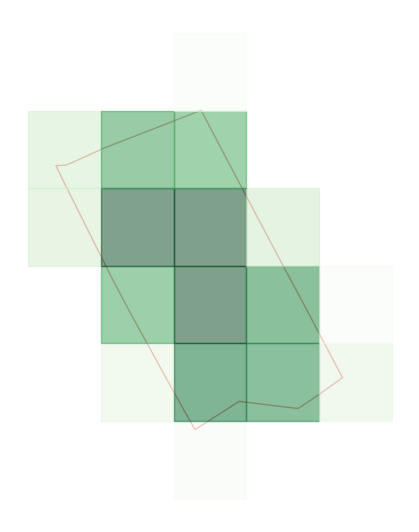

In [19]:
my_cmap = cm.get_cmap('Greens')
my_norm = colrs.Normalize(vmin = 0, vmax=1)

min_x, min_y, max_x, max_y = city_shape.bounds
ratio = (max_y - min_y)/(max_x - min_x)

dim_width = 4
dim_height = dim_width *ratio

fig = plt.figure(figsize=(dim_width, dim_height))
ax = fig.add_axes([0, 0, 1, 1])

patch = PolygonPatch(iris_shape, fc='white', ec='tab:red', alpha=.5, lw=1)
ax.add_patch(patch)

for (cell_id, cell_shape, ratio) in cell_ids:

    color = colrs.to_hex(my_cmap(my_norm(ratio)))

    patch = PolygonPatch(cell_shape, fc=color, ec=color, alpha=.5, lw=1)
    ax.add_patch(patch)

plt.autoscale(True)
plt.axis('off')

plt.show()

In [20]:
df_iris_city['cell_ids'] = df_iris_city.apply(lambda row: get_cell_ids(row['geometry_ntf']), axis=1)

# remove iris without cell
df_iris_city['len_cell_ids'] = df_iris_city.apply(lambda row: len(row['cell_ids']), axis=1)
df_iris_city = df_iris_city[df_iris_city['len_cell_ids'] > 0].copy()
df_iris_city.head(2)

,iris_code,geometry,geometry_ntf,city,iris_inside_ratio,iris_index,cell_ids,len_cell_ids
36,920440109,"POLYGON ((48.89379 2.29154, 48.89362 2.29113, ...","POLYGON ((596701.1538090943 2432835.103953797,...",Paris,1.0,0,"[(95256, POLYGON ((596600 2432700, 596600 2432...",17
57,930270105,"POLYGON ((48.92059 2.41055, 48.91992 2.40987, ...","POLYGON ((605429.7061786579 2435817.931119842,...",Paris,1.0,1,"[(105030, POLYGON ((605200 2435500, 605200 243...",63


In [21]:
df_iris_city['cell_ids'] = df_iris_city.apply(lambda row: [(cell_id, ratio) for (cell_id, _, ratio) in row['cell_ids']], axis=1)
df_iris_city = df_iris_city.explode('cell_ids')
df_iris_city['cell_id'] = df_iris_city.apply(lambda row: row['cell_ids'][0], axis=1)
df_iris_city['ratio'] = df_iris_city.apply(lambda row: row['cell_ids'][1], axis=1)
df_iris_city = df_iris_city.drop(columns=['cell_ids'])

df_iris_city.head(2)

,iris_code,geometry,geometry_ntf,city,iris_inside_ratio,iris_index,len_cell_ids,cell_id,ratio
36,920440109,"POLYGON ((48.89379 2.29154, 48.89362 2.29113, ...","POLYGON ((596701.1538090943 2432835.103953797,...",Paris,1.0,0,17,95256,0.013668
36,920440109,"POLYGON ((48.89379 2.29154, 48.89362 2.29113, ...","POLYGON ((596701.1538090943 2432835.103953797,...",Paris,1.0,0,17,95601,0.113252


In [23]:
df_iris_city = df_iris_city[['iris_index', 'iris_code', 'cell_id', 'ratio', 'geometry']].copy()
df_iris_city.head(2)

,iris_index,iris_code,cell_id,ratio,geometry
36,0,920440109,95256,0.013668,"POLYGON ((48.89379 2.29154, 48.89362 2.29113, ..."
36,0,920440109,95601,0.113252,"POLYGON ((48.89379 2.29154, 48.89362 2.29113, ..."


## Save data

In [24]:
df_iris_city.to_pickle(f'{DATA_DIR}/cell_iris_ratio/df_ratio_{CITY_NAME}.pkl')